# Calculate Evenness

For the Network Resiliency project, we have outlined a process in the `PseudoCode` document for calculating resiliency as as a property of a network which has a commodity flowed over it.

After the baseline link flows and O-D costs have been calculated for the network, the outputs in the database will be link_flows, unmet demand (if any), and total cost. 

## Extracting node and link values from db

- After running a quick start scenario, output database exists as `main.db`
- Connect to the database and extract the following
    + From **`networkx_edges`**, get `miles`, `capacity`, and `volume`.
    + The **`edges`** table includes `networkx_edges` output, as well as additional features. Notable are `edge_flow_cost` (and `edge_flow_cost2`), `max_edge_capacity`, and `volume` (background flow, existing volume)
    + **`optimal_variables`** table is the edges in the optimal solution. `var_id` is the edge ID. 
    + **`optimal_solution`** includes the `variable_value` for the volume of flow. For edges which are in sequence, the value will be identical
    + Get `dollar_cost` and `routing_cost` out of **`optimal_scenario_results`** table. `routing_cost` is the better one to use for us. Use the `mode == _total` rows of this.

Links meet at nodes, which are not just intersections but also areas where the functional class or other attributes changes.


## Calculation of evenness

1. As a screening approach. Given a network with capacity and baseline flow, calculate the following metrics, Simpson's E and Shannon Evenness:

**Simpson's E evenness**: 
$$
E = \frac{1/D}{S_{obs}}
$$

Where $D$ is dominance:
$$
\sum{p^2_i}
$$

and $p$ is proportion of the community represented by species $i$.

Here we use links as 'species', and `capac_minus_volume_zero_floor` from `edges` to calculate $p$.

**Shannon Evenness**:

$$
E_H = \frac{H'}{H_{max}}
$$

Where

$$
H' = - \sum_{i=1}^S{ p_i \ln p_i}
$$

$$
H_{max} = \ln S
$$


2. As a performance-measurement approach. Use volume of goods flowing on the links in an optimal solution, as well as just the links used in the optimal solution. This would be very similar to the screening approach, except using just the links involved in the optimal solution, and use the realized flow for the $p$ proportion represented by this link 

*References*
- http://www.tiem.utk.edu/~gross/bioed/bealsmodules/simpsonDI.html


## What should we use as $p$?

- Volume
- Available capacity
- Distance
- Sum of betweeness centrality of nodes

Proposal:

Calculate Evenness (using Shannon Evenness) using each one of these.

TODO: 

- How should we deal with the multi-modal aspect of the network? We will have an evenness measure for each mode.


In [1]:
def evenness_metrics(dbname, use_mode = 'road'):
    """Function to calculate evenness of network using four different measures of link importance.
    
    dbname should be the full path to the FTOT database, main.db
    use_mode should be what part of the transportation network to use. Currently just one string, can flex to a list
    For example: dbname= C:\FTOT\scenarios\quick_start\qs7_rmp_proc_dest_multi_inputs\main.db
    It will read from the `edges` table of that database.
    """
    import os
    import sqlalchemy
    import pandas as pd
    import numpy as np
    
    db_path = 'sqlite:///' + os.path.join(dbname)
    engine = sqlalchemy.create_engine(db_path)
    table_name = 'edges'
    edges = pd.read_sql_table(table_name, engine)
    # Subset to just the target transportation modes
    # and keep only unique edges
    edges = edges[edges['mode'] == use_mode] 
    edges = edges.drop_duplicates(subset=['mode_oid'])
    
    S = edges.shape[0]
    Hmax = np.log(S)
    
    metric_list = []
    
    weighted_metric_list = []
    
    # Available Capacity
    
    sum_weight = edges['capac_minus_volume_zero_floor'].sum()
    props = edges['capac_minus_volume_zero_floor'] / sum_weight 
    # np.nansum(props) == 1 # Must equal 1, add this as a stopping criterion
       
    Hprime = -1 * np.nansum(np.log(props).multiply(props))
    Evenness_capac = Hprime / Hmax
    
    metric_list.append(Evenness_capac)

    weighted_metric_list.append(sum_weight * Evenness_capac)

    # Volume

    sum_weight = edges['volume'].sum()
    props = edges['volume'] / sum_weight   
    Hprime = -1 * np.nansum(np.log(props).multiply(props))
    Evenness_vol = Hprime / Hmax
   
    metric_list.append(Evenness_vol)

    weighted_metric_list.append(sum_weight * Evenness_vol)

    # Length

    sum_weight = edges['miles'].sum()
    props = edges['miles'] / sum_weight 
    Hprime = -1 * np.nansum(np.log(props).multiply(props))
    Evenness_dist = Hprime / Hmax
    
    metric_list.append(Evenness_dist)

    weighted_metric_list.append(sum_weight * Evenness_dist)

    
    metric_df = pd.DataFrame(zip(metric_list, weighted_metric_list),
                             columns = ['Evenness', 'Weighted_Evenness'],
                             index = ['Evenness_AvailCapac', 'Evenness_Vol', 'Evenness_Len'])
    
            
    return metric_df
    

In [2]:
import os
import sqlalchemy
import pandas as pd
import numpy as np


scenario_path = r'C:\FTOT\scenarios\quick_start\qs7_MA'
dbname = os.path.join(scenario_path, 'main.db')
use_mode = 'road'
db_path = 'sqlite:///' + os.path.join(dbname)
engine = sqlalchemy.create_engine(db_path)
table_name = 'edges'
edges = pd.read_sql_table(table_name, engine)
# Subset to just the target transportation modes

edges = edges[edges['mode'] == use_mode] 

# Keep only unique edges 
edges['mode_oid'].unique()

array([ 26662., 127482., 127494., ..., 152452.,  74113.,  74648.])

In [3]:
edges = edges.drop_duplicates(subset=['mode_oid'])

In [4]:
S = edges.shape[0]
Hmax = np.log(S)

metric_list = []

weighted_metric_list = []

# Available Capacity

sum_weight = edges['capac_minus_volume_zero_floor'].sum()
props = edges['capac_minus_volume_zero_floor'] / sum_weight 
# np.nansum(props) == 1 # Must equal 1, add this as a stopping criterion

Hprime = -1 * np.nansum(np.log(props).multiply(props))
Evenness_capac = Hprime / Hmax

metric_list.append(Evenness_capac)

weighted_metric_list.append(sum_weight * Evenness_capac)

# Volume

sum_weight = edges['volume'].sum()
props = edges['volume'] / sum_weight   
Hprime = -1 * np.nansum(np.log(props).multiply(props))
Evenness_vol = Hprime / Hmax
   

C:\Users\Daniel.Flynn\Anaconda3\envs\geoenv\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A591644430>,
      dtype=object)

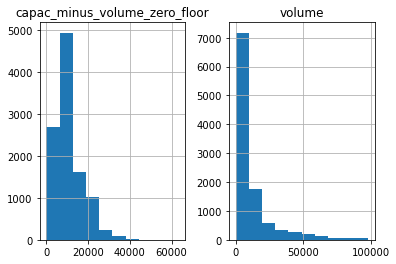

In [5]:
edges.hist(column = ['capac_minus_volume_zero_floor', 'volume'])

In [6]:
print(len(props[props == 0]))
print(len(props))
print(sum_weight)

51
17685
202789207.0


In [7]:
print(Hprime)
print(Hmax)



9.234793935044813
9.780472101639582


In [14]:
import os

scenario_path = r'C:\FTOT\scenarios\quick_start\qs7_MA'
db_name = 'main.db'

qs7_MA_metrics = evenness_metrics(os.path.join(scenario_path, db_name))

qs7_MA_metrics

C:\Users\Daniel.Flynn\Anaconda3\envs\geoenv\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Evenness,Weighted_Evenness
Evenness_AvailCapac,0.976462,1.095331e+08
Evenness_Vol,0.941005,1.212170e+08
Evenness_Len,0.912689,7.020738e+03


In [15]:
scenario_path = r'C:\FTOT\scenarios\quick_start\qs7_MA_2'

qs7_MA_2_metrics = evenness_metrics(os.path.join(scenario_path, db_name))

qs7_MA_2_metrics

C:\Users\Daniel.Flynn\Anaconda3\envs\geoenv\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Evenness,Weighted_Evenness
Evenness_AvailCapac,0.973289,6.188130e+07
Evenness_Vol,0.940965,7.677854e+07
Evenness_Len,0.923700,3.265362e+03


In [16]:
scenario_path = r'C:\FTOT\scenarios\quick_start\qs7_OH'

qs7_OH_metrics = evenness_metrics(os.path.join(scenario_path, db_name))

qs7_OH_metrics

C:\Users\Daniel.Flynn\Anaconda3\envs\geoenv\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Evenness,Weighted_Evenness
Evenness_AvailCapac,0.983258,1.162214e+08
Evenness_Vol,0.945740,6.756334e+07
Evenness_Len,0.918740,6.264291e+03


In [17]:
scenario_path = r'C:\FTOT\scenarios\quick_start\qs7_OH_2'

qs7_OH_2_metrics = evenness_metrics(os.path.join(scenario_path, db_name))

qs7_OH_2_metrics

C:\Users\Daniel.Flynn\Anaconda3\envs\geoenv\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Evenness,Weighted_Evenness
Evenness_AvailCapac,0.977828,4.485254e+07
Evenness_Vol,0.924557,3.350801e+07
Evenness_Len,0.901109,2.715985e+03


In [18]:
scenario_path = r'C:\FTOT\scenarios\quick_start\qs7_CA'

qs7_CA_metrics = evenness_metrics(os.path.join(scenario_path, db_name))

qs7_CA_metrics

C:\Users\Daniel.Flynn\Anaconda3\envs\geoenv\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Evenness,Weighted_Evenness
Evenness_AvailCapac,0.958629,9.566684e+07
Evenness_Vol,0.929806,2.112799e+08
Evenness_Len,0.907912,9.223271e+03


In [ ]:
scenario_path = r'C:\FTOT\scenarios\quick_start\qs7_CA_2'

qs7_CA_2_metrics = evenness_metrics(os.path.join(scenario_path, db_name))

qs7_CA_2_metrics